In [32]:
import os
import random
import librosa
import numpy as np
import soundfile as sf
from pydub import AudioSegment
from pydub.exceptions import CouldntDecodeError

# Define paths
base_path = "C:\\Users\\azatv\\\Jupyter\\JupyterProjects\\ML and PC\\mlpc_dataset_with just_words"
output_path = "C:\\Users\\azatv\\Jupyter\\JupyterProjects\\ML and PC\\dataset"
os.makedirs(output_path, exist_ok=True)
os.makedirs(os.path.join(output_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'labels'), exist_ok=True)

# Define directories
directories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
noise_dir = os.path.join(base_path, "other")
["Alarm", "Fernseher","Heizung", "Licht", "Lüftung", "Ofen", "Radio", "Staubsauger"]
[Alarm,
an,
aus,
Brötchen,
Fernseher,
Haus,
Heizung,
kann,
Leitung,
Licht,
Lüftung,
nicht,
Ofen,
offen,
other,
Radio,
Schraube,
Spiegel,
Staubsauger,
warm,
wunderbar]


# Helper function to load audio files
def load_audio(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        return audio, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

# Helper function to add noise to audio
def add_noise(audio, noise_files, sr):
    noise_file = random.choice(noise_files)
    print(noise_file)
    noise_audio, _ = load_audio(noise_file)
    if noise_audio is not None:
        noise_audio = librosa.util.fix_length(noise_audio, size=len(audio))
        return audio + noise_audio * 0.05  # Adjust noise level
    return audio

# Helper function to save audio and labels
def save_audio_and_labels(audio, sr, label, file_name):
    output_audio_path = os.path.join(output_path, 'images', file_name + ".wav")
    output_label_path = os.path.join(output_path, 'labels', file_name + ".txt")
    sf.write(output_audio_path, audio, sr)
    with open(output_label_path, 'w') as f:
        f.write(label)

# Get all noise files
noise_files = [os.path.join(noise_dir, str(f).replace('._','')) for f in os.listdir(noise_dir) if f.endswith('.wav')]

# Process each word directory
for _ in range(10):  # Generate 10 samples
    selected_words = random.sample(directories, 3)  # Select 3 random words
    combined_audio = np.array([])
    labels = []

    for word in selected_words:
        word_dir = os.path.join(base_path, word)
        #print(os.listdir(word_dir))
        word_files = [os.path.join(word_dir, str(f).replace('._','')) for f in os.listdir(word_dir) if f.endswith('.wav')]
        word_file = random.choice(word_files)
        audio, sr = load_audio(word_file)
        if audio is None:
            continue  # Skip if audio couldn't be loaded
        audio = librosa.util.fix_length(audio, size=int(10 * sr))  # Ensure each clip is 10 seconds
        combined_audio = np.concatenate((combined_audio, audio))
        labels.append(f"{word} 0.5 0.5 1.0 1.0")  # Dummy coordinates and class

    if len(combined_audio) == 0:
        continue  # Skip if no valid audio files were found

    # Add random noise
    combined_audio = add_noise(combined_audio, noise_files, sr)

    # Save combined audio and labels
    file_name = f"sample_{random.randint(1000, 9999)}"
    save_audio_and_labels(combined_audio, sr, "\n".join(labels), file_name)


C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\mlpc_dataset_with just_words\other\2024_15_speech_true.wav
C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\mlpc_dataset_with just_words\other\1686_6_speech_true.wav
C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\mlpc_dataset_with just_words\other\1234_6_speech_true.wav
C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\mlpc_dataset_with just_words\other\1476_7_speech_true.wav
C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\mlpc_dataset_with just_words\other\1567_1_speech_true.wav
C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\mlpc_dataset_with just_words\other\1308_5_speech_true.wav
C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\mlpc_dataset_with just_words\other\493_13_speech_true.wav
C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\mlpc_dataset_with just_words\other\1147_14_speech_false.wav
C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\mlpc_dataset_with just_words\other\196_7_speech_true.wav
C:\Users\azatv\Jupyter\JupyterProje

In [11]:
import os
print(os.getcwdb())

b'c:\\Users\\azatv\\Jupyter\\JupyterProjects\\ML and PC'


In [160]:
import os
import random
import librosa
import numpy as np
import soundfile as sf
import cv2
import matplotlib.pyplot as plt
import sounddevice as sd

# Define paths
base_path = "C:\\Users\\azatv\\Jupyter\\JupyterProjects\\ML and PC\\mlpc_dataset_with just_words"
output_path = "C:\\Users\\azatv\\Jupyter\\JupyterProjects\\ML and PC\\dataset_test"
os.makedirs(output_path, exist_ok=True)
os.makedirs(os.path.join(output_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'labels'), exist_ok=True)

# Define directories
word_groups = {
    "group1": ["Alarm", "Fernseher", "Heizung", "Licht", "Luftung", "Ofen", "Radio", "Staubsauger"],
    "group2": ["Brotchen", "Haus", "kann", "Leitung", "nicht", "offen", "Schraube", "Spiegel", "warm", "wunderbar"],
    "actions": ["an", "aus"]
}
noise_dir = os.path.join(base_path, "other")

# Helper function to load audio files
def load_audio(file_path):
    try:
        audio, sr = librosa.load(file_path)
        return audio, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

# Helper function to add noise to audio
def add_noise(noise_files, sr, duration):
    noise_file = random.choice(noise_files)
    print(f"Adding noise from file: {noise_file}")
    noise_audio, sr = load_audio(noise_file)
    if noise_audio is not None:
        noise_audio = librosa.util.fix_length(noise_audio, size=int(duration * sr))
        return noise_audio * 0.05  # Adjust noise level
    return np.zeros(int(duration * sr))  # Return silence if noise file fails

# Helper function to save audio and labels
def save_audio_and_labels(audio, sr, labels, file_name):
    output_audio_path = os.path.join(output_path, 'images', file_name + ".wav")
    output_label_path = os.path.join(output_path, 'labels', file_name + ".txt")
    print(f"Saving audio to {output_audio_path}")
    print(f"Saving labels to {output_label_path}")
    sf.write(output_audio_path, audio, sr)
    with open(output_label_path, 'w') as f:
        f.write("\n".join(labels))

# Helper function to convert audio to spectrogram and save
def save_spectrogram(audio, sr, file_name, n_fft=2048, hop_length=512):
    # Compute the spectrogram
    S = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))
    print(np.shape(S))
    
    # Compute to dB
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    # Normalize spectrogram
    S_db_normalized = cv2.normalize(S_db, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    image = S_db_normalized.astype(np.uint8)

    # Save the image
    output_image_path = os.path.join(output_path, 'images', file_name + ".png")
    cv2.imwrite(output_image_path, image)
    print(f"Spectrogram saved to {output_image_path}")

# Get all noise files
noise_files = [os.path.join(noise_dir, str(f).replace('._', '')) for f in os.listdir(noise_dir) if f.endswith('.wav')]
print(f"Found noise files: {noise_files}")

def create_combination(word_group, action_group, noise_files, sr, include_additional_command, n_fft=2048, hop_length=512):
    selected_word = random.choice(word_group)
    selected_action = random.choice(action_group)
    combined_audio = np.array([])
    labels = []
    words_included = [selected_word, selected_action]

    total_duration = 0
    num_frames = 0
    segments = []

    # Add random noise at the beginning
    noise_duration = random.uniform(1, 3)
    combined_audio = np.concatenate((combined_audio, add_noise(noise_files, sr, noise_duration)))
    total_duration += noise_duration

    # Add selected word
    word_dir = os.path.join(base_path, selected_word)
    word_files = [os.path.join(word_dir, str(f).replace('._', '')) for f in os.listdir(word_dir) if f.endswith('.wav')]
    word_file = random.choice(word_files)
    print(f"Adding word from file: {word_file}")
    audio, _ = load_audio(word_file)
    if audio is not None:
        word_start = total_duration
        combined_audio = np.concatenate((combined_audio, audio))
        word_end = total_duration + len(audio) / sr
        total_duration += len(audio) / sr
        segments.append((selected_word, word_start, word_end))

    # Add action word
    action_dir = os.path.join(base_path, selected_action)
    action_files = [os.path.join(action_dir, str(f).replace('._', '')) for f in os.listdir(action_dir) if f.endswith('.wav')]
    action_file = random.choice(action_files)
    print(f"Adding action from file: {action_file}")
    action_audio, _ = load_audio(action_file)
    if action_audio is not None:
        action_start = total_duration
        combined_audio = np.concatenate((combined_audio, action_audio))
        action_end = total_duration + len(action_audio) / sr
        total_duration += len(action_audio) / sr
        segments.append((selected_action, action_start, action_end))

    # Optionally add additional commands
    if include_additional_command:
        num_additional_words = random.randint(0, 3)  # Select 1 to 3 additional words
        additional_words = random.sample(word_groups["group2"], num_additional_words)
        for additional_word in additional_words:
            additional_word_dir = os.path.join(base_path, additional_word)
            additional_word_files = [os.path.join(additional_word_dir, str(f).replace('._', '')) for f in os.listdir(additional_word_dir) if f.endswith('.wav')]
            additional_word_file = random.choice(additional_word_files)
            print(f"Adding additional word from file: {additional_word_file}")
            additional_audio, _ = load_audio(additional_word_file)
            if additional_audio is not None:
                additional_start = total_duration
                combined_audio = np.concatenate((combined_audio, additional_audio))
                additional_end = total_duration + len(additional_audio) / sr
                total_duration += len(additional_audio) / sr
                segments.append((additional_word, additional_start, additional_end))
                words_included.append(additional_word)

    # Add random noise at the end
    noise_duration = random.uniform(1, 3)
    combined_audio = np.concatenate((combined_audio, add_noise(noise_files, sr, noise_duration)))
    total_duration += noise_duration

    # Ensure the final length is between 12 and 30 seconds
    target_duration = random.uniform(12, 30)
    if total_duration < target_duration:
        additional_noise_duration = target_duration - total_duration
        combined_audio = np.concatenate((combined_audio, add_noise(noise_files, sr, additional_noise_duration)))
        total_duration += additional_noise_duration

    # Trim the audio to the target duration if necessary
    if total_duration > target_duration:
        combined_audio = combined_audio[:int(target_duration * sr)]

    # Calculate label parameters for each segment
    for word, start, end in segments:
        x = (start + end) / 2 / total_duration
        width = (end - start) / total_duration
        y = 0.5
        height = 1
        labels.append(f"{word} {x} {y} {width} {height}")

    return combined_audio, labels, total_duration, words_included

# Process each word directory
for i in range(10):  # Generate 10 samples
    # Select a random word group and action group
   
    word_group = word_groups["group1"]

    action_group = word_groups["actions"]

    # Determine if an additional command should be included
    include_additional_command = random.random() < 0.7  # 10-30% probability

    combined_audio, labels, total_duration, words_included = create_combination(word_group, action_group, noise_files, sr, include_additional_command)
    
    if len(combined_audio) == 0:
        print("Skipping sample due to invalid audio.")
        continue  # Skip if no valid audio files were found

    # Create the file name
    file_name = f"{i}_{'_'.join(words_included)}"

    # Save combined audio and labels
    save_audio_and_labels(combined_audio, sr, labels, file_name)

    # Save the spectrogram image
    save_spectrogram(combined_audio, sr, file_name, n_fft=2048, hop_length=512)


###### Working 


Found noise files: ['C:\\Users\\azatv\\Jupyter\\JupyterProjects\\ML and PC\\mlpc_dataset_with just_words\\other\\100_0_speech_false.wav', 'C:\\Users\\azatv\\Jupyter\\JupyterProjects\\ML and PC\\mlpc_dataset_with just_words\\other\\100_10_speech_false.wav', 'C:\\Users\\azatv\\Jupyter\\JupyterProjects\\ML and PC\\mlpc_dataset_with just_words\\other\\100_11_speech_false.wav', 'C:\\Users\\azatv\\Jupyter\\JupyterProjects\\ML and PC\\mlpc_dataset_with just_words\\other\\100_12_speech_false.wav', 'C:\\Users\\azatv\\Jupyter\\JupyterProjects\\ML and PC\\mlpc_dataset_with just_words\\other\\100_13_speech_false.wav', 'C:\\Users\\azatv\\Jupyter\\JupyterProjects\\ML and PC\\mlpc_dataset_with just_words\\other\\100_14_speech_false.wav', 'C:\\Users\\azatv\\Jupyter\\JupyterProjects\\ML and PC\\mlpc_dataset_with just_words\\other\\100_15_speech_false.wav', 'C:\\Users\\azatv\\Jupyter\\JupyterProjects\\ML and PC\\mlpc_dataset_with just_words\\other\\100_16_speech_false.wav', 'C:\\Users\\azatv\\Jupyter\\J

In [158]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

# Define paths
output_path = "C:\\Users\\azatv\\Jupyter\\JupyterProjects\\ML and PC\\dataset_test"

# Function to load and parse the labels
def load_labels(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    labels = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            label = {
                'word': parts[0],
                'x': float(parts[1]),
                'y': float(parts[2]),
                'width': float(parts[3]),
                'height': float(parts[4])
            }
            labels.append(label)
    return labels

# Function to play specific word
def play_word(audio, sr, label, total_duration):
    start_time = (label['x'] - (label['width'] / 2)) * total_duration
    end_time = (label['x'] + (label['width'] / 2)) * total_duration
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    
    print(f"Playing word '{label['word']}' from {start_time:.2f}s to {end_time:.2f}s ({start_sample} to {end_sample} samples)")

    if end_sample > len(audio):
        end_sample = len(audio)

    word_audio = audio[start_sample:end_sample]

    if np.max(np.abs(word_audio)) > 0:
        word_audio = word_audio / np.max(np.abs(word_audio))  # Normalize to -1 to 1
    word_audio = word_audio * 0.5  # Adjust volume if needed

    sd.play(word_audio, sr)
    sd.wait()

# List all generated files
wav_files = [f for f in os.listdir(os.path.join(output_path, 'images')) if f.endswith('.wav')]
txt_files = [f for f in os.listdir(os.path.join(output_path, 'labels')) if f.endswith('.txt')]
png_files = [f for f in os.listdir(os.path.join(output_path, 'images')) if f.endswith('.png')]

# Ensure there are files to process
if not wav_files or not txt_files or not png_files:
    print("No files found to process.")
else:
    # Select a file to test
    test_index = 0
    wav_file = os.path.join(output_path, 'images', wav_files[test_index])
    txt_file = os.path.join(output_path, 'labels', txt_files[test_index])
    png_file = os.path.join(output_path, 'images', png_files[test_index])

    print(f"Testing file: {wav_file}")
    
    # Load the audio file
    audio, sr = librosa.load(wav_file, sr=None)

    # Load the labels
    labels = load_labels(txt_file)

    # Compute the total duration of the audio
    total_duration = len(audio) / sr

    # Display the spectrogram image
    plt.imshow(plt.imread(png_file))
    plt.title(f"Spectrogram: {wav_files[test_index]}")
    plt.show()

    # Play the specific words based on the labels
    for label in labels:
        print(f"Playing word: {label['word']}")
        play_word(audio, sr, label, total_duration)


No files found to process.


Testing file: C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\dataset_test\images\0_warm_aus.wav


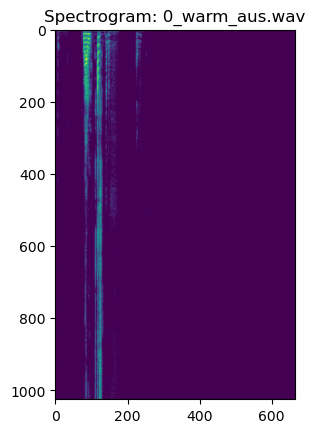

Playing word: warm
Playing word 'warm' from 10.42s to 15.40s (229678 to 339515 samples)
Playing word: aus
Playing word 'aus' from 11.63s to 15.40s (256526 to 339515 samples)


In [146]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

# Define paths
output_path = "C:\\Users\\azatv\\Jupyter\\JupyterProjects\\ML and PC\\dataset_test"

# Function to load and parse the labels
def load_labels(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    labels = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            label = {
                'word': parts[0],
                'x': float(parts[1]),
                'y': float(parts[2]),
                'width': float(parts[3]),
                'height': float(parts[4])
            }
            labels.append(label)
    return labels

# Function to play specific word
def play_word(audio, sr, label, total_duration):
    start_time = (label['x'] - (label['width'] / 2)) * total_duration
    end_time = (label['x'] + (label['width'] / 2)) * total_duration
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    
    print(f"Playing word '{label['word']}' from {start_time:.2f}s to {end_time:.2f}s ({start_sample} to {end_sample} samples)")

    if end_sample > len(audio):
        end_sample = len(audio)

    word_audio = audio[start_sample:end_sample]

    if np.max(np.abs(word_audio)) > 0:
        word_audio = word_audio / np.max(np.abs(word_audio))  # Normalize to -1 to 1
    word_audio = word_audio * 0.5  # Adjust volume if needed

    sd.play(word_audio, sr)
    sd.wait()

# List all generated files
wav_files = [f for f in os.listdir(os.path.join(output_path, 'images')) if f.endswith('.wav')]
txt_files = [f for f in os.listdir(os.path.join(output_path, 'labels')) if f.endswith('.txt')]
png_files = [f for f in os.listdir(os.path.join(output_path, 'images')) if f.endswith('.png')]

# Ensure there are files to process
if not wav_files or not txt_files or not png_files:
    print("No files found to process.")
else:
    # Select a file to test
    test_index = 0
    wav_file = os.path.join(output_path, 'images', wav_files[test_index])
    txt_file = os.path.join(output_path, 'labels', txt_files[test_index])
    png_file = os.path.join(output_path, 'images', png_files[test_index])

    print(f"Testing file: {wav_file}")
    
    # Load the audio file
    audio, sr = librosa.load(wav_file, sr=None)

    # Load the labels
    labels = load_labels(txt_file)

    # Compute the total duration of the audio
    total_duration = len(audio) / sr

    # Display the spectrogram image
    plt.imshow(plt.imread(png_file))
    plt.title(f"Spectrogram: {wav_files[test_index]}")
    plt.show()

    # Play the specific words based on the labels
    for label in labels:
        print(f"Playing word: {label['word']}")
        play_word(audio, sr, label, total_duration)
